In [1]:
# ! LOAD MODULES
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib as mpl
import itertools
import sys
import os
import re

from os import listdir
from os.path import isfile, join
import os
import sys

from collections import Counter, defaultdict
from multiprocessing import Pool

from scipy.stats import pearsonr, linregress, spearmanr,zscore
from scipy.stats import wilcoxon,mannwhitneyu,kruskal,f_oneway,ttest_ind, fisher_exact

from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_predict,cross_val_score,cross_validate
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, roc_auc_score,precision_score, confusion_matrix
from sklearn.decomposition import IncrementalPCA,PCA
from sklearn.manifold import TSNE
from sklearn import cluster

import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from scipy import cluster,stats
from scipy.cluster.hierarchy import fcluster

import plotly as plotly
import plotly.graph_objs as go
import plotly.plotly as plty 
import plotly.offline as py_o
import plotly.figure_factory as ff
plotly.tools.set_credentials_file(username='kevin-hu', api_key='lqhCQjrtitKdFlSZmkJd')
py_o.init_notebook_mode(connected=True)

from matplotlib import rc
plt.rcParams['ps.useafm'] = True
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

sys.path.append(os.path.relpath("../../helper"))

import name_mappings
import helper_stats
import helper_plots

import importlib
importlib.reload(helper_stats)
importlib.reload(helper_plots)

sns.set_style('white', {'axes.linewidth': 0.5})
plt.rcParams['xtick.major.size'] = 8
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.size'] = 8
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

sns.set_style("ticks")

# Load estimates

## ENSEMBL transcript annotations

In [16]:
ensembl_transcripts = pd.read_csv("../data/kallisto/kallisto_files/ensembl_75_transcripts.csv",index_col=2)
ensembl_transcripts["hgnc_symbol"] = ensembl_transcripts["hgnc_symbol"].fillna("Unnamed")

ensembl_transcripts = ensembl_transcripts.loc[~ensembl_transcripts.index.duplicated(keep='first')]

ensembl_transcripts.columns = ["n","ensembl_gene_id"]+list(ensembl_transcripts.columns[2:])

ensembl_transcripts["format_gene_id"] = ensembl_transcripts["hgnc_symbol"] + \
    "_" + ensembl_transcripts["ensembl_gene_id"]

gene_id_map = dict(zip(ensembl_transcripts["ensembl_gene_id"],ensembl_transcripts["format_gene_id"]))

## Sleuth outputs

In [174]:
rpl22_oe = pd.read_csv("../data/kallisto/kallisto_sleuth/RPL22_oe.csv",index_col=1)
rpl22l1_oe = pd.read_csv("../data/kallisto/kallisto_sleuth/RPL22L1_oe.csv",index_col=1)
sh704 = pd.read_csv("../data/kallisto/kallisto_sleuth/sh704.csv",index_col=1)
sh705 = pd.read_csv("../data/kallisto/kallisto_sleuth/sh705.csv",index_col=1)

rpl22_oe = rpl22_oe.join(ensembl_transcripts,how="inner")
rpl22l1_oe = rpl22l1_oe.join(ensembl_transcripts,how="inner")
sh704 = sh704.join(ensembl_transcripts,how="inner")
sh705 = sh705.join(ensembl_transcripts,how="inner")

In [175]:
rpl22_oe_ranks = rpl22_oe[rpl22_oe["hgnc_symbol"]!="Unnamed"]
rpl22l1_oe_ranks = rpl22l1_oe[rpl22l1_oe["hgnc_symbol"]!="Unnamed"]
sh704_ranks = sh704[sh704["hgnc_symbol"]!="Unnamed"]
sh705_ranks = sh705[sh705["hgnc_symbol"]!="Unnamed"]

sh704_ranks["b"] = -sh704_ranks["b"]
sh705_ranks["b"] = -sh705_ranks["b"]

rpl22_oe_ranks = rpl22_oe_ranks.dropna(subset=["b"])
rpl22l1_oe_ranks = rpl22l1_oe_ranks.dropna(subset=["b"])
sh704_ranks = sh704_ranks.dropna(subset=["b"])
sh705_ranks = sh705_ranks.dropna(subset=["b"])

rpl22_oe_ranks["b_abs"] = np.abs(rpl22_oe_ranks["b"])
rpl22l1_oe_ranks["b_abs"] = np.abs(rpl22l1_oe_ranks["b"])
sh704_ranks["b_abs"] = np.abs(sh704_ranks["b"])
sh705_ranks["b_abs"] = np.abs(sh705_ranks["b"])

rpl22_oe_ranks = rpl22_oe_ranks.sort_values(by="b_abs",ascending=False)
rpl22l1_oe_ranks = rpl22l1_oe_ranks.sort_values(by="b_abs",ascending=False)
sh704_ranks = sh704_ranks.sort_values(by="b_abs",ascending=False)
sh705_ranks = sh705_ranks.sort_values(by="b_abs",ascending=False)

# rpl22_oe_ranks = rpl22_oe_ranks[rpl22_oe_ranks["qval"]<0.01]
# rpl22l1_oe_ranks = rpl22l1_oe_ranks[rpl22l1_oe_ranks["qval"]<0.01]
# sh704_ranks = sh704_ranks[sh704_ranks["qval"]<0.01]
# sh705_ranks = sh705_ranks[sh705_ranks["qval"]<0.01]

rpl22_oe_ranks = rpl22_oe_ranks.drop_duplicates(keep="first",subset=["hgnc_symbol"])
rpl22l1_oe_ranks = rpl22l1_oe_ranks.drop_duplicates(keep="first",subset=["hgnc_symbol"])
sh704_ranks = sh704_ranks.drop_duplicates(keep="first",subset=["hgnc_symbol"])
sh705_ranks = sh705_ranks.drop_duplicates(keep="first",subset=["hgnc_symbol"])

rpl22_oe_ranks = rpl22_oe_ranks.sort_values(by="b",ascending=False)
rpl22l1_oe_ranks = rpl22l1_oe_ranks.sort_values(by="b",ascending=False)
sh704_ranks = sh704_ranks.sort_values(by="b",ascending=False)
sh705_ranks = sh705_ranks.sort_values(by="b",ascending=False)

rpl22_oe_ranks = rpl22_oe_ranks.set_index("hgnc_symbol")
rpl22l1_oe_ranks = rpl22l1_oe_ranks.set_index("hgnc_symbol")
sh704_ranks = sh704_ranks.set_index("hgnc_symbol")
sh705_ranks = sh705_ranks.set_index("hgnc_symbol")

In [177]:
rpl22_oe_ranks[["b"]].to_csv("../data/gsea/rpl22_oe_ranks.csv")
rpl22l1_oe_ranks[["b"]].to_csv("../data/gsea/rpl22l1_oe_ranks.csv")
sh704_ranks[["b"]].to_csv("../data/gsea/sh704_ranks.csv")
sh705_ranks[["b"]].to_csv("../data/gsea/sh705_ranks.csv")

In [185]:
select_gene = "MDM4"

display(rpl22_oe_ranks[rpl22_oe_ranks.index.map(lambda x: select_gene in x)])
display(rpl22l1_oe_ranks[rpl22l1_oe_ranks.index.map(lambda x: select_gene in x)])
display(sh704_ranks[sh704_ranks.index.map(lambda x: select_gene in x)])
display(sh705_ranks[sh705_ranks.index.map(lambda x: select_gene in x)])


,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,n,ensembl_gene_id,ensembl_peptide_id,transcript_biotype,transcript_status,format_gene_id,b_abs
hgnc_symbol,,,,,,,,,,,,,,,,,,
MDM4,4524,0.054079,0.71576,2.081809,1.080782,2.486372,2.701886,1.057806,0.694328,0.477744,0.694328,37623,ENSG00000198625,ENSP00000375811,protein_coding,KNOWN,MDM4_ENSG00000198625,2.081809


,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,n,ensembl_gene_id,ensembl_peptide_id,transcript_biotype,transcript_status,format_gene_id,b_abs
hgnc_symbol,,,,,,,,,,,,,,,,,,
MDM4,14221,0.03085,0.129777,1.742148,0.806922,4.564619,1.200226,0.815292,-0.453164,0.161394,0.161394,37613,ENSG00000198625,NaN,processed_transcript,KNOWN,MDM4_ENSG00000198625,1.742148


,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,n,ensembl_gene_id,ensembl_peptide_id,transcript_biotype,transcript_status,format_gene_id,b_abs
hgnc_symbol,,,,,,,,,,,,,,,,,,
MDM4,4517,0.011871,0.149865,3.214183,1.277524,0.913944,3.12496,1.066514,-1.034428,1.381586,1.381586,37617,ENSG00000198625,ENSP00000356147,protein_coding,KNOWN,MDM4_ENSG00000198625,3.214183


,target_id,pval,qval,b,se_b,mean_obs,var_obs,tech_var,sigma_sq,smooth_sigma_sq,final_sigma_sq,n,ensembl_gene_id,ensembl_peptide_id,transcript_biotype,transcript_status,format_gene_id,b_abs
hgnc_symbol,,,,,,,,,,,,,,,,,,
MDM4,5476,0.005736,0.067059,3.267554,1.182829,0.94063,3.207643,0.822713,-0.817002,1.275912,1.275912,37617,ENSG00000198625,ENSP00000356147,protein_coding,KNOWN,MDM4_ENSG00000198625,3.267554


## Kallisto estimates

## Make transcript expression matrix

In [3]:
samples = pd.read_csv("../data/kallisto/paired_samples.txt",names=["folder"])
samples["S"] = samples["folder"].apply(lambda x: int(x.split("_")[-1][1:]))
samples = samples.sort_values(by="S")

merged_tpms = []

for sample in samples["folder"]:
    transcript_abundances = pd.read_csv("../data/kallisto/kallisto_quant/"+sample+"/abundance.tsv",
                                        sep="\t",
                                        index_col=0
                                       )
    
    merged_tpms.append(transcript_abundances["tpm"].rename(sample))
    
merged_tpms = pd.concat(merged_tpms,axis=1)

merged_tpms.to_csv("../data/kallisto/merged_tpms.csv")

## Make gene expression matrix

In [9]:
_,align_ensembl_genes = merged_tpms.align(ensembl_transcripts["ensembl_gene_id"],axis=0,join="inner")

In [25]:
gene_tpms = merged_tpms.groupby(align_ensembl_genes).sum().T
gene_tpms.columns = gene_tpms.columns.map(lambda x: gene_id_map[x])

In [129]:
def plot_tpm_dist(gene_id):
    
    select_abundance = np.array(gene_tpms[gene_id])

    expression_df = pd.DataFrame()

    expression_df["Gene TPM"] = list(select_abundance[[0, 1, 2, 6, 7, 8, 12, 13, 14, 12, 13, 14]]) + list(
        select_abundance[[3, 4, 5, 9, 10, 11, 15, 16, 17, 18, 19, 20]])

    expression_df["treatment"] = ["Control"]*12 + ["Treatment"]*12

    expression_df["Experiment"] = (
        ["RPL22++"]*3 + ["RPL22L1++"]*3 + ["sh704"]*3 + ["sh705"]*3)*2

    expression_df.index = list(gene_tpms.index[[0, 1, 2, 6, 7, 8, 12, 13, 14, 12, 13, 14]]) + list(
        gene_tpms.index[[3, 4, 5, 9, 10, 11, 15, 16, 17, 18, 19, 20]])
    
    plt.figure(figsize=(4, 2.5))

    sns.barplot(x="Experiment",
                y="Gene TPM",
                data=expression_df,
                hue="treatment",
                palette={"Control": "#e3e3e3", "Treatment": "#286DC0"},
                ci=None)

    ax = sns.stripplot(x="Experiment",
                       y="Gene TPM",
                       data=expression_df,
                       hue="treatment",
                       dodge=True,
                       palette={"Control": "#e3e3e3", "Treatment": "#286DC0"},
                       size=8,
                       jitter=False,
                       linewidth=2,
                       edgecolor="black",
                       alpha=0.75
                      )

    ax.get_legend().remove()

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.ylim(0)
    
    plt.title(gene_id.split("_")[0])
    
    plt.savefig("../plots/"+gene_id+"_expression_distribution.pdf",bbox_inches="tight")


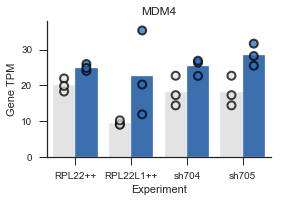

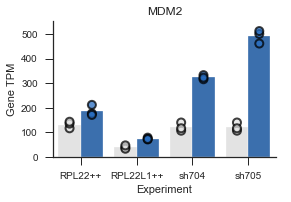

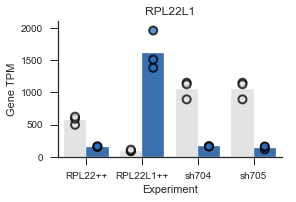

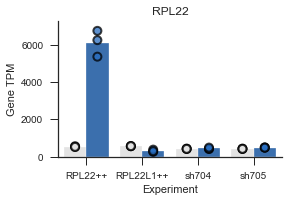

In [130]:
plot_tpm_dist("MDM4_ENSG00000198625")
plot_tpm_dist("MDM2_ENSG00000135679")
plot_tpm_dist("RPL22L1_ENSG00000163584")
plot_tpm_dist("RPL22_ENSG00000116251")